In [2]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from  matplotlib.ticker import PercentFormatter
from matplotlib.backends.backend_pdf import PdfPages
pd.set_option('use_inf_as_na', True)
pd.options.display.max_columns = 50
sns.set(context = 'paper', style='whitegrid', font_scale=1.8, rc = {'axes.spines.right':False, 'axes.spines.top': False, 'figure.figsize':(12.7,8.6)}, palette='Set1')


## Bubble chart

* Please ensure to have xlrd installed on your local machine by running the following command:
pip install xlrd
* The basic idea of the bubble chart is to create a scatterplot where we update the size of the bubble based on the GBD population equivalent of the outcome

* The bubble chart is aggregate across the 5 years of the sim (2020-2024)
* Incidence of IHD and Stroke (MACE)
* Deaths of IHD and Stroke (CV deaths)


In [13]:
zenon_data_output = pd.read_excel('Zenon Data Output - May 2020.xlsx', sheet_name='full_data_output_table')
zenon_data_output = zenon_data_output[(zenon_data_output['Age group'] == '40+') & (zenon_data_output['Sex'] == 'Both') & (zenon_data_output['Subpopulation (measured at start of simulation)'] == 'Entire population')]
mace_data_source = zenon_data_output[(zenon_data_output['Outcome'] == 'Incidence of IHD') | (zenon_data_output['Outcome'] == 'Incidence of Ischemic stroke')]
mace_data_source = mace_data_source.groupby(['Location name', 'Subpopulation (measured at start of simulation)', 'Age group', 'Sex', 'Scenario']).sum().reset_index()
mace_data_source['Outcome'] = 'MACE'
cv_deaths_data_source = zenon_data_output[(zenon_data_output['Outcome'] =='Mortality due to IHD') | (zenon_data_output['Outcome'] =='Mortality due to Ischemic stroke')]
cv_deaths_data_source = cv_deaths_data_source.groupby(['Location name', 'Subpopulation (measured at start of simulation)', 'Age group', 'Sex', 'Scenario']).sum().reset_index()
cv_deaths_data_source['Outcome'] = 'CV deaths'
bubble_data_set = pd.concat([mace_data_source, cv_deaths_data_source])
bubble_data_set['Year'] = '2020-2024'
data_source_bau = bubble_data_set[(bubble_data_set['Scenario'] == 'Business as Usual')]
shared_columns = ['Location name', 'Year', 'Subpopulation (measured at start of simulation)', 'Age group', 'Sex', 'Outcome']
data_source = pd.merge(bubble_data_set, data_source_bau[['Location name', 'Year', 'Subpopulation (measured at start of simulation)', 'Age group', 'Sex', 'Outcome', 'Population counts estimate', 'Population counts- difference from baseline estimate']], left_on=shared_columns, right_on=shared_columns, how='left')
data_source['Percent Difference from BAU'] = data_source.apply(lambda row: (row['Population counts- difference from baseline estimate_x']/ row['Population counts estimate_y']),axis=1)
data_source = data_source.rename(columns={'Population counts- difference from baseline estimate_x':'Population counts- difference from baseline estimate'})
data_source_plot = data_source.groupby(['Location name', 'Scenario']).sum().reset_index()
data_source_plot = data_source_plot[['Location name', 'Scenario']]
data_source_mace = data_source[(data_source['Outcome'] == 'MACE')]
data_source_mace = data_source_mace.rename(columns={'Percent Difference from BAU':'Percent reduction in MACE', 'Population counts- difference from baseline estimate':'MACE Population counts- difference from baseline'})
data_source_cv_deaths = data_source[(data_source['Outcome'] == 'CV deaths')]
data_source_cv_deaths = data_source_cv_deaths.rename(columns={'Percent Difference from BAU':'Percent reduction in CV deaths', 'Population counts- difference from baseline estimate':'CV Deaths Population counts- difference from baseline'})
shared_columns_transpose = ['Location name', 'Scenario']
data_source_plot= pd.merge(data_source_plot, data_source_mace[['Location name', 'Scenario', 'Percent reduction in MACE', 'MACE Population counts- difference from baseline']], left_on=shared_columns_transpose, right_on=shared_columns_transpose)
data_source_plot = pd.merge(data_source_plot, data_source_cv_deaths[['Location name', 'Scenario', 'Percent reduction in CV deaths', 'CV Deaths Population counts- difference from baseline']], left_on=shared_columns_transpose, right_on=shared_columns_transpose)
data_source_plot['Percent reduction in MACE'] = data_source_plot['Percent reduction in MACE'] * 100
data_source_plot['Percent reduction in CV deaths'] = data_source_plot['Percent reduction in CV deaths'] * 100



/ihme/code/central_comp/miniconda3_10_30_2019/envs/v94/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
/ihme/code/central_comp/miniconda3_10_30_2019/envs/v94/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
/ihme/code/central_comp/miniconda3_10_30_2019/envs/v94/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


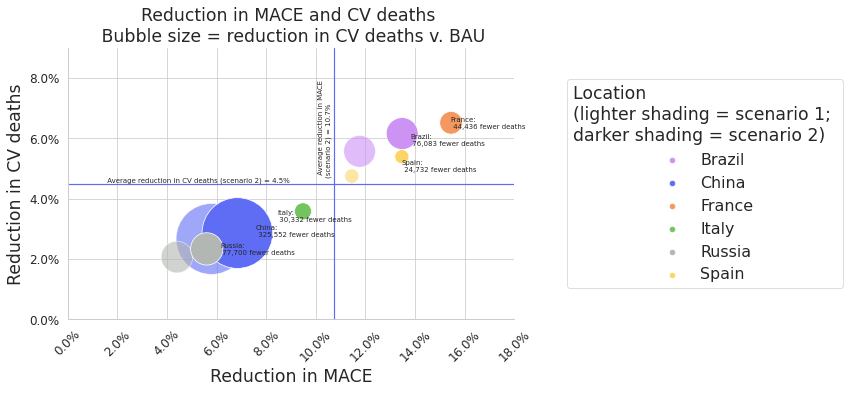

<Figure size 914.4x619.2 with 0 Axes>

In [14]:
def get_bubble_chart(data_source_plot):
    data_1 = data_source_plot[(data_source_plot['Scenario'] == 'Intervention 1 (multiple pills)')]
    data_2 = data_source_plot[(data_source_plot['Scenario'] == 'Intervention 2 (FDC)')]

    location_list = ['Brazil', 'China', 'France', 'Italy', 'Russia', 'Spain']
    palette_list = ['#CC92F4','#5F6CF4','#F4985F', '#73C45E', '#B3B7B3', '#FDD566']
    palette_dict = {x:v for x,v in zip(location_list,palette_list)}
    
    with PdfPages(f'reduction_in_mace_cv_deaths_bubble_chart.pdf') as pdf:

        fig, ax = plt.subplots(figsize=(8, 5))
        
        g = sns.scatterplot(x='Percent reduction in MACE', y='Percent reduction in CV deaths', hue='Location name',
                                         ax=ax, size='CV Deaths Population counts- difference from baseline', sizes=(200, 5000), alpha=0.6, palette=palette_dict, data=data_1)
        sns.scatterplot(x='Percent reduction in MACE', y='Percent reduction in CV deaths', hue='Location name',
                                        size='CV Deaths Population counts- difference from baseline', ax=ax, sizes=(200, 5000), legend=False, palette=palette_dict, data=data_2)

        plt.title(f'Reduction in MACE and CV deaths \n Bubble size = reduction in CV deaths v. BAU')

        x=data_1['Percent reduction in MACE'] + 1.5
        x=x.tolist()
        y=data_1['Percent reduction in CV deaths'].to_list()
        
        n = ['Brazil:\n 76,083 fewer deaths', 'China:\n 325,552 fewer deaths', 'France:\n 44,436 fewer deaths', 'Italy:\n 30,332 fewer deaths', 'Russia:\n 77,700 fewer deaths', 'Spain:\n 24,732 fewer deaths' ]    
        for i, txt in enumerate(n):
            ax.annotate(txt, (x[i], y[i]), textcoords='offset points', fontsize=7)
        
        plt.axvline(10.718994, color='#5F6CF4', linestyle='solid')
        plt.text(10.1, 4.75, r' Average reduction in MACE', rotation='vertical', fontsize = 7)
        plt.text(10.4, 4.75, r'(scenario 2) = 10.7%', rotation='vertical', fontsize = 7)

        
        plt.axhline(4.472394, color='#5F6CF4', linestyle='solid')
        plt.text(1.5, 4.55, r' Average reduction in CV deaths (scenario 2) = 4.5%', rotation='horizontal', fontsize = 7)

        
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12)
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)

        plt.xlabel('Reduction in MACE')
        plt.ylabel('Reduction in CV deaths')

        handles,labels=g.get_legend_handles_labels()
        handle_dict={}
        for i in range(len(handles)):
            handle_dict[labels[i]]=handles[i]
        labels.remove('CV Deaths Population counts- difference from baseline')
        labels.remove('Location name')

        sorted_labels=sorted(labels)
        sorted_handles=[handle_dict[x] for x in sorted_labels]
        sorted_handles = sorted_handles[5:]
        sorted_labels = sorted_labels[5:]
        plt.legend(sorted_handles, sorted_labels, loc='center left', title='Location \n(lighter shading = scenario 1; \ndarker shading = scenario 2)', bbox_to_anchor=(1.10, 0.5), ncol=1)

        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        ax.xaxis.set_major_formatter(mtick.PercentFormatter())
        g.set_ylim(0, 9)
        g.set_xlim(0, 18)
        pdf.savefig(fig, orientation = 'landscape', bbox_inches='tight')
        plt.show()
        plt.clf()
        
get_bubble_chart(data_source_plot)

## Bar charts

In [123]:
zenon_data_output = pd.read_excel('Zenon Data Output - May 2020.xlsx', sheet_name='full_data_output_table')
zenon_data_output_bar_chart = zenon_data_output[(zenon_data_output['Age group'] == '40+') & (zenon_data_output['Sex'] == 'Both') & (zenon_data_output['Subpopulation (measured at start of simulation)'] != 'Entire population')]
mace_data_source = zenon_data_output_bar_chart[(zenon_data_output_bar_chart['Outcome'] == 'Incidence of IHD') | (zenon_data_output_bar_chart['Outcome'] == 'Incidence of Ischemic stroke')]
mace_data_source = mace_data_source.groupby(['Location name', 'Subpopulation (measured at start of simulation)', 'Age group', 'Sex', 'Scenario']).sum().reset_index()
mace_data_source['Outcome'] = 'MACE'
cv_deaths_data_source = zenon_data_output_bar_chart[(zenon_data_output_bar_chart['Outcome'] =='Mortality due to IHD') | (zenon_data_output_bar_chart['Outcome'] =='Mortality due to Ischemic stroke')]
cv_deaths_data_source = cv_deaths_data_source.groupby(['Location name', 'Subpopulation (measured at start of simulation)', 'Age group', 'Sex', 'Scenario']).sum().reset_index()
cv_deaths_data_source['Outcome'] = 'CV deaths'
barchart_data_set = pd.concat([mace_data_source, cv_deaths_data_source])
barchart_data_set['Year'] = '2020-2024'
data_source_bau = barchart_data_set[(barchart_data_set['Scenario'] == 'Business as Usual')]
shared_columns = ['Location name', 'Year', 'Subpopulation (measured at start of simulation)', 'Age group', 'Sex', 'Outcome']
data_source = pd.merge(barchart_data_set, data_source_bau[['Location name', 'Year', 'Subpopulation (measured at start of simulation)', 'Age group', 'Sex', 'Outcome', 'Population counts estimate', 'Population counts- difference from baseline estimate']], left_on=shared_columns, right_on=shared_columns, how='left')
data_source['Percent Difference from BAU'] = data_source.apply(lambda row: (row['Population counts- difference from baseline estimate_x']/ row['Population counts estimate_y']),axis=1)
data_source = data_source.rename(columns={'Population counts- difference from baseline estimate_x':'Population counts- difference from baseline estimate'})
data_source = data_source[['Location name', 'Subpopulation (measured at start of simulation)', 'Scenario', 'Outcome', 'Percent Difference from BAU']]


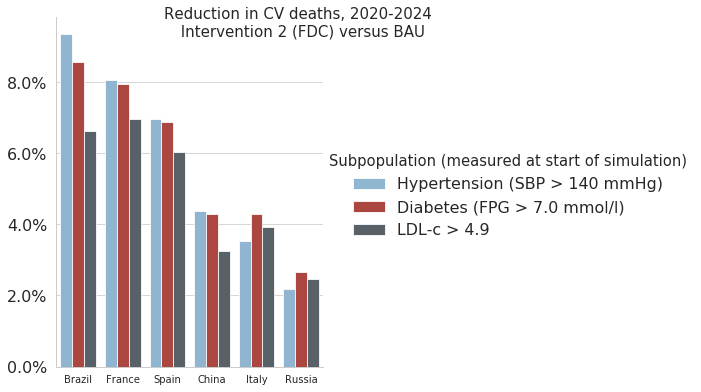

<Figure size 914.4x619.2 with 0 Axes>

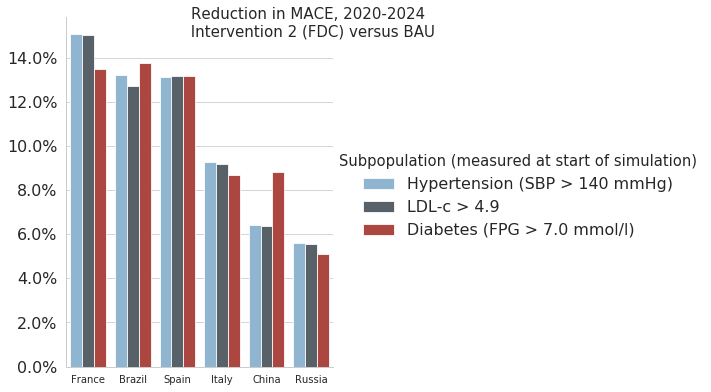

<Figure size 914.4x619.2 with 0 Axes>

In [200]:
def reduction_in_outcomes_barchart(data_source):
    outcomes = ['CV deaths', 'MACE']
    scenario_list = ['Diabetes (FPG > 7.0 mmol/l)','Hypertension (SBP > 140 mmHg)', 'LDL-c > 4.9']
    palette_list = ['#BD362F','#84B7DB','#556169']
    
    df = data_source
    palette_dict = {x:v for x,v in zip(scenario_list,palette_list)}
    with PdfPages('reduction_in_mace_cv_deaths_barchart.pdf') as pdf:
        for measure in outcomes:

            data_bar = df[(df['Outcome'] == measure) & (df['Scenario'] == 'Intervention 2 (FDC)')].sort_values(by=['Percent Difference from BAU'], ascending=[False])

            g = sns.catplot(x="Location name", y= "Percent Difference from BAU", hue="Subpopulation (measured at start of simulation)", data=data_bar, palette = palette_dict,
                                height=6, kind="bar")

            g.fig.suptitle(f'Reduction in {measure}, 2020-2024 \n Intervention 2 (FDC) versus BAU', fontsize=15)

            plt.xticks(fontsize=10)
            g.set_xlabels('', fontsize=10)
            g.set_ylabels('', fontsize=10)

            for ax in g.axes.flat:
                ax.yaxis.set_major_formatter(PercentFormatter(1))
            plt.show()        

            pdf.savefig(g.fig, orientation = 'landscape', bbox_inches='tight')

            plt.show()
            plt.clf() 
            

reduction_in_outcomes_barchart(data_source)

## Stacked bar chart

In [ ]:
zenon_data_output = pd.read_excel('Zenon Data Output - May 2020.xlsx', sheet_name='full_data_output_table')
zenon_data_output_bar_chart = zenon_data_output[(zenon_data_output['Age group'] == '40+') & (zenon_data_output['Sex'] == 'Both') & (zenon_data_output['Subpopulation (measured at start of simulation)'] == 'Entire population')]
mace_data_source = zenon_data_output_bar_chart[(zenon_data_output_bar_chart['Outcome'] == 'Incidence of IHD') | (zenon_data_output_bar_chart['Outcome'] == 'Incidence of Ischemic stroke')]
mace_data_source = mace_data_source.groupby(['Location name', 'Subpopulation (measured at start of simulation)', 'Age group', 'Sex', 'Scenario']).sum().reset_index()
mace_data_source['Outcome'] = 'MACE'
cv_deaths_data_source = zenon_data_output_bar_chart[(zenon_data_output_bar_chart['Outcome'] =='Mortality due to IHD') | (zenon_data_output_bar_chart['Outcome'] =='Mortality due to Ischemic stroke')]
cv_deaths_data_source = cv_deaths_data_source.groupby(['Location name', 'Subpopulation (measured at start of simulation)', 'Age group', 'Sex', 'Scenario']).sum().reset_index()
cv_deaths_data_source['Outcome'] = 'CV deaths'
barchart_data_set = pd.concat([mace_data_source, cv_deaths_data_source])
barchart_data_set['Year'] = '2020-2024'
data_source_bau = barchart_data_set[(barchart_data_set['Scenario'] == 'Business as Usual')]
shared_columns = ['Location name', 'Year', 'Subpopulation (measured at start of simulation)', 'Age group', 'Sex', 'Outcome']
data_source = pd.merge(barchart_data_set, data_source_bau[['Location name', 'Year', 'Subpopulation (measured at start of simulation)', 'Age group', 'Sex', 'Outcome', 'Population counts estimate', 'Population counts- difference from baseline estimate']], left_on=shared_columns, right_on=shared_columns, how='left')
data_source['Percent Difference from BAU'] = data_source.apply(lambda row: (row['Population counts- difference from baseline estimate_x']/ row['Population counts estimate_y']),axis=1)
data_source = data_source.rename(columns={'Population counts- difference from baseline estimate_x':'Population counts- difference from baseline estimate'})
data_source_scen2 = data_source[(data_source['Scenario'] == 'Intervention 2 (FDC)')]
shared_columns = ['Location name', 'Year', 'Subpopulation (measured at start of simulation)', 'Age group', 'Sex', 'Outcome']
data_source = pd.merge(data_source, data_source_scen2[['Location name', 'Year', 'Subpopulation (measured at start of simulation)', 'Age group', 'Sex', 'Outcome', 'Percent Difference from BAU']], left_on=shared_columns, right_on=shared_columns, how='left')
data_source = data_source[(data_source['Scenario'] == 'Intervention 1 (multiple pills)')]
data_source = data_source.rename(columns={'Percent Difference from BAU_x':'Scenario 1', 'Percent Difference from BAU_y':'Scenario 2'})
data_source = data_source[['Location name', 'Outcome', 'Scenario 1', 'Scenario 2']]
data_source['Percent Difference between Scenario 1 and 2'] = data_source.apply(lambda row: ((row['Scenario 2'] - row['Scenario 1'])*100),axis=1)


In [10]:
data_source

,Location name,Outcome,Scenario 1,Scenario 2,Percent Difference between Scenario 1 and 2
1,Brazil,MACE,0.117617,0.134796,1.717900
4,China,MACE,0.057913,0.068361,1.044761
7,France,MACE,0.133313,0.154513,2.119981
10,Italy,MACE,0.066023,0.094797,2.877431
13,Russia,MACE,0.043972,0.056003,1.203101
16,Spain,MACE,0.114496,0.134669,2.017349
19,Brazil,CV deaths,0.055666,0.061548,0.588191
22,China,CV deaths,0.026646,0.028612,0.196586
25,France,CV deaths,0.061018,0.065108,0.408951
28,Italy,CV deaths,0.031267,0.035809,0.454259


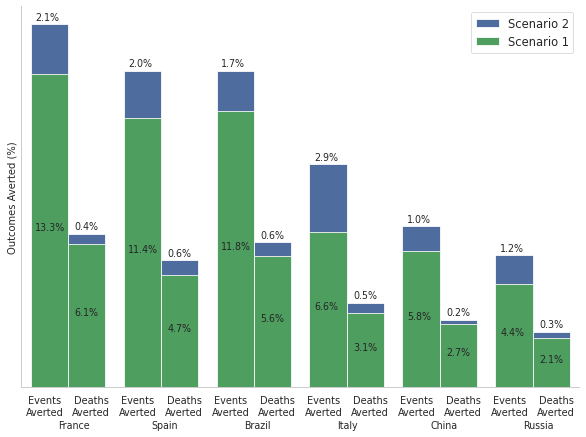

<Figure size 914.4x619.2 with 0 Axes>

In [12]:
def reduction_in_outcomes_stacked_barchart(data_source):
    outcomes = ['Scenario 1', 'Scenario 2']
    palette_list = ['#41AB59','#4169AB']

    palette_dict = {x:v for x,v in zip(outcomes,palette_list)}

    with PdfPages('reduction_in_mace_cv_deaths_stacked_barchart.pdf') as pdf:
        
        fig, ax = plt.subplots(figsize=(10,7))
        
        data_source = data_source.sort_values(by=['Outcome'], ascending=False)

        sns.barplot(x='Location name', y= 'Scenario 2', hue='Outcome', order=['France', 'Spain', 'Brazil', 'Italy', 'China', 'Russia'], palette=[palette_list[1]], data= data_source)
        g = sns.barplot(x='Location name', y= 'Scenario 1', hue='Outcome', order=['France', 'Spain', 'Brazil', 'Italy', 'China', 'Russia'], palette=[palette_list[0]], data= data_source)

        plt.xlabel('', fontsize=10)
        plt.ylabel('Outcomes Averted (%)', fontsize=10)
        plt.yticks([])

        g.set_xticks([-0.25, .25, .75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25])
        g.set_xticklabels(labels=['Events\nAverted', 'Deaths\nAverted', 'Events\nAverted', 'Deaths\nAverted', 'Events\nAverted', 'Deaths\nAverted', 'Events\nAverted', 'Deaths\nAverted', 'Events\nAverted', 'Deaths\nAverted', 'Events\nAverted', 'Deaths\nAverted'], fontsize=9.75)
        handles = g.get_legend_handles_labels()[0][1:3]
        labels = ['France', 'Spain', 'Brazil', 'Italy', 'China', 'Russia']
        for i in range(len(labels)):
            plt.text((i - 0.1), -0.0175, labels[i], fontsize=9.5)
        
        i = 0
        xticks = [-0.25, .25, .75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25]
        for loc in labels:
            for outcome in ['MACE', 'CV deaths']:
                df = data_source[(data_source['Location name'] == loc) & (data_source['Outcome'] == outcome)]
                if (i+1)%2 == 0 and i != 0:
                    plt.text((xticks[i]-0.175), df['Scenario 1']/2, str((df['Scenario 1'].values[0]*100).round(1))+'%', fontsize=9.5)
                    plt.text((xticks[i]-0.175), df['Scenario 2']+.002, str((df['Percent Difference between Scenario 1 and 2'].values[0]).round(1))+'%', fontsize=9.5)                
                else:
                    plt.text((xticks[i]-0.1), df['Scenario 1']/2, str((df['Scenario 1'].values[0]*100).round(1))+'%', fontsize=9.5)
                    plt.text((xticks[i]-0.1), df['Scenario 2']+.002, str((df['Percent Difference between Scenario 1 and 2'].values[0]).round(1))+'%', fontsize=9.5)                

                i+=1
        plt.legend(handles, ['Scenario 2', 'Scenario 1'], fontsize=11.5)
        pdf.savefig(fig, orientation = 'landscape', bbox_inches='tight')

        plt.show()
        plt.clf() 
            
reduction_in_outcomes_stacked_barchart(data_source)